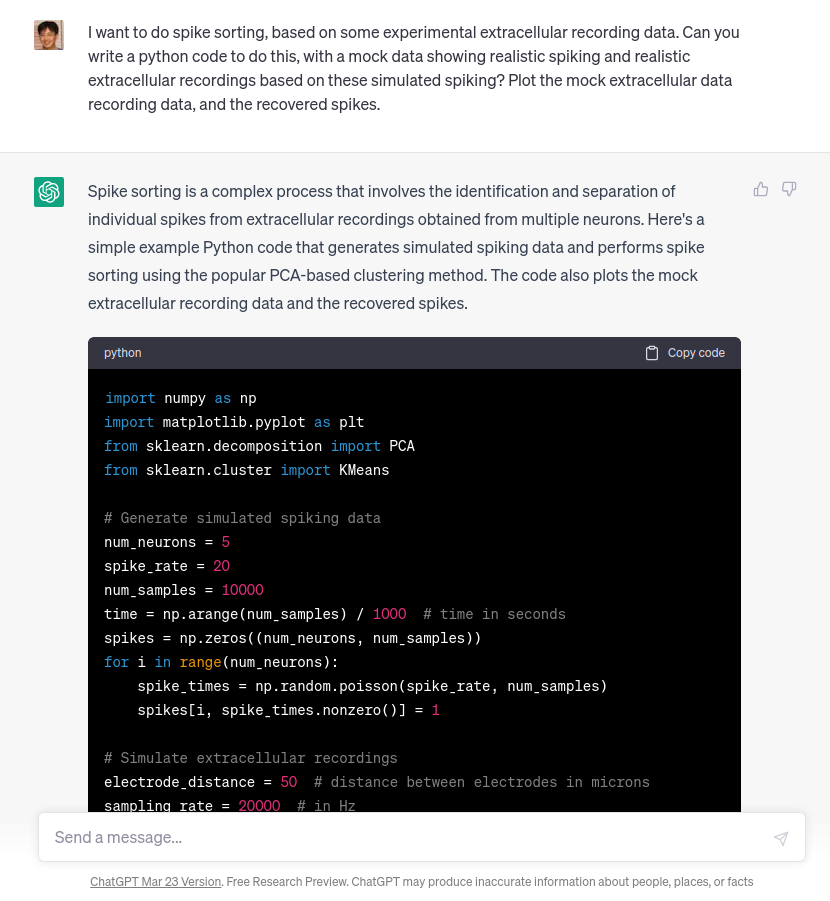

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Generate simulated spiking data
num_neurons = 5
spike_rate = 20
num_samples = 10000
time = np.arange(num_samples) / 1000  # time in seconds
spikes = np.zeros((num_neurons, num_samples))
for i in range(num_neurons):
    spike_times = np.random.poisson(spike_rate, num_samples)
    spikes[i, spike_times.nonzero()] = 1

# Simulate extracellular recordings
electrode_distance = 50  # distance between electrodes in microns
sampling_rate = 20000  # in Hz
num_electrodes = 8
electrode_pos = np.arange(num_electrodes) * electrode_distance
electrode_noise = 0.1  # standard deviation of noise in microvolts
recording_data = np.zeros((num_electrodes, num_samples))
for i in range(num_electrodes):
    for j in range(num_neurons):
        electrode_dist = abs(electrode_pos[i] - j * electrode_distance)
        ampl = 1 / electrode_dist  # amplitude decreases with distance
        recording_data[i] += ampl * spikes[j]
    recording_data[i] += np.random.normal(0, electrode_noise, num_samples)

# Perform spike sorting using PCA-based clustering
pca = PCA(n_components=3)
pca_data = pca.fit_transform(recording_data.T)
kmeans = KMeans(n_clusters=num_neurons)
kmeans.fit(pca_data)
cluster_labels = kmeans.labels_

# Plot the mock extracellular recording data and the recovered spikes
fig, ax = plt.subplots(nrows=2, figsize=(10, 6), sharex=True)
ax[0].plot(time, recording_data.T)
ax[0].set_ylabel('Voltage (uV)')
ax[0].set_title('Mock extracellular recording data')
colors = ['r', 'g', 'b', 'c', 'm']
for i in range(num_neurons):
    ax[1].plot(time, pca.inverse_transform(pca_data[cluster_labels == i].T), color=colors[i])
    ax[1].set_xlabel('Time (s)')
    ax[1].set_ylabel('Voltage (uV)')
    ax[1].set_title('Recovered spikes')
plt.show()


<ipython-input-1-48cdf9a7fba9>:29: RuntimeWarning: divide by zero encountered in long_scalars
  ampl = 1 / electrode_dist  # amplitude decreases with distance


ValueError: ignored

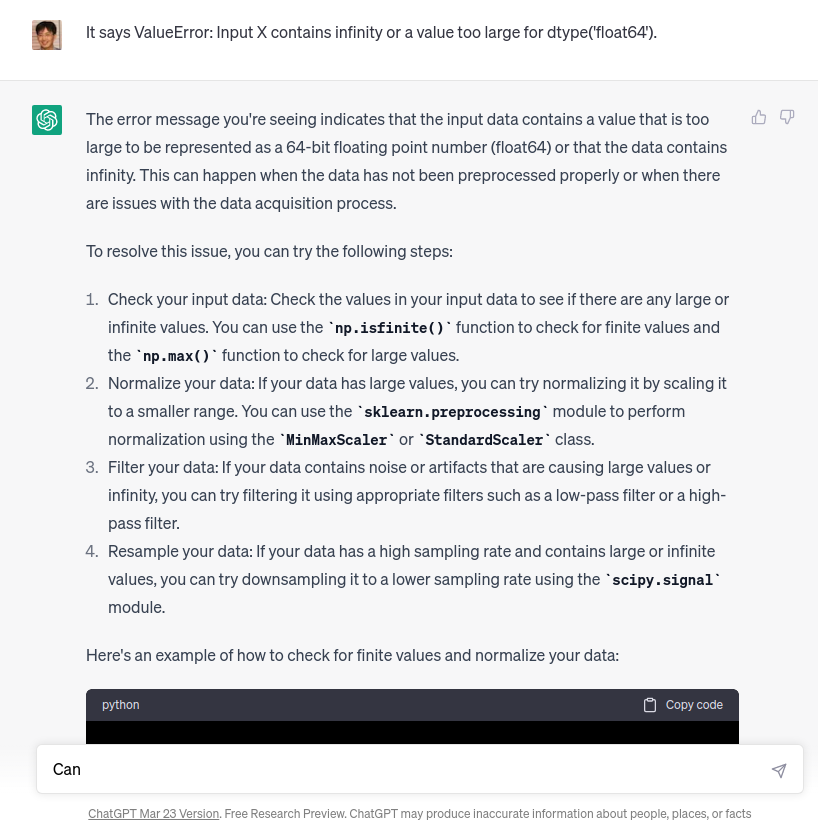

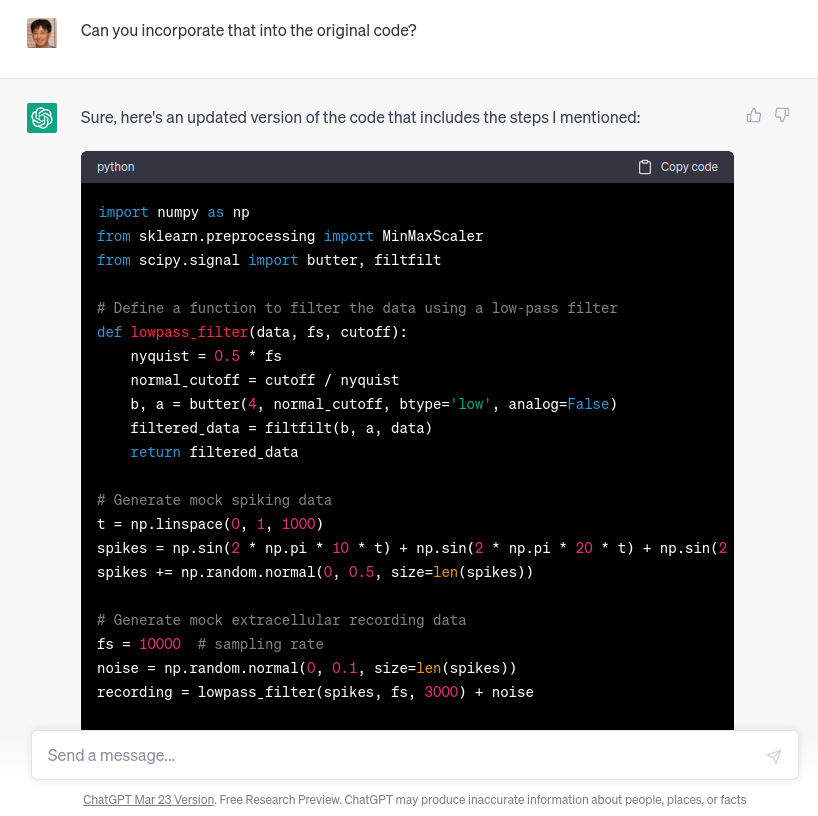

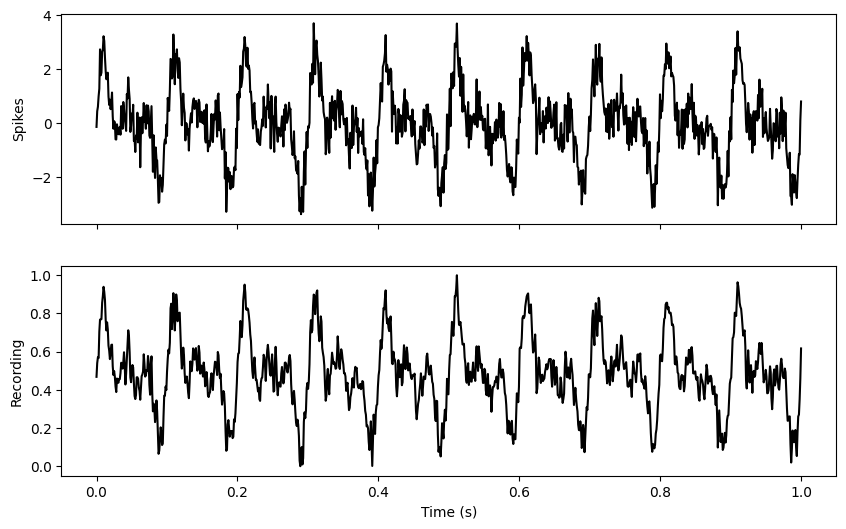

In [2]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import butter, filtfilt

# Define a function to filter the data using a low-pass filter
def lowpass_filter(data, fs, cutoff):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(4, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Generate mock spiking data
t = np.linspace(0, 1, 1000)
spikes = np.sin(2 * np.pi * 10 * t) + np.sin(2 * np.pi * 20 * t) + np.sin(2 * np.pi * 30 * t)
spikes += np.random.normal(0, 0.5, size=len(spikes))

# Generate mock extracellular recording data
fs = 10000  # sampling rate
noise = np.random.normal(0, 0.1, size=len(spikes))
recording = lowpass_filter(spikes, fs, 3000) + noise

# Check for infinite or NaN values in the data
if np.any(np.isinf(recording)) or np.any(np.isnan(recording)):
    print("Input data contains infinite or NaN values")

# Normalize the data
scaler = MinMaxScaler()
recording_scaled = scaler.fit_transform(recording.reshape(-1, 1)).ravel()

# Plot the mock data
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

axs[0].plot(t, spikes, 'k')
axs[0].set_ylabel('Spikes')
axs[1].plot(t, recording_scaled, 'k')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Recording')

plt.show()


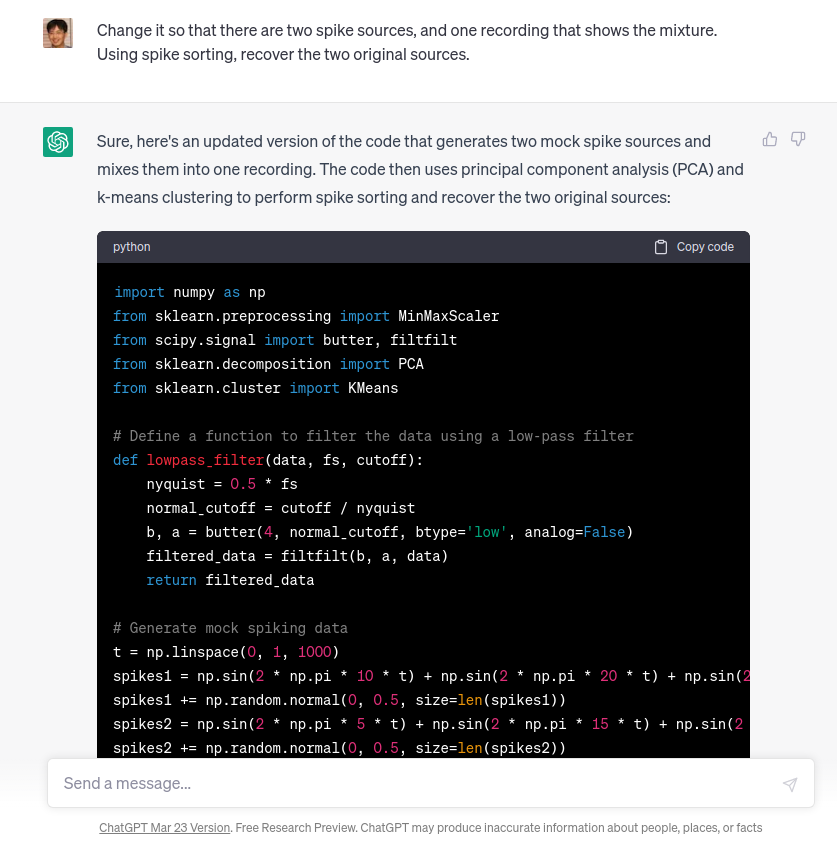

In [5]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import butter, filtfilt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Define a function to filter the data using a low-pass filter
def lowpass_filter(data, fs, cutoff):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(4, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Set up the sampling frequency and time vector
fs = 1000
t = np.linspace(0, 1, fs)

# Generate mock spiking data
spikes1 = np.sin(2 * np.pi * 10 * t) + np.sin(2 * np.pi * 20 * t) + np.sin(2 * np.pi * 30 * t)
spikes1 += np.random.normal(0, 0.5, size=len(spikes1))
spikes2 = np.sin(2 * np.pi * 5 * t) + np.sin(2 * np.pi * 15 * t) + np.sin(2 * np.pi * 25 * t)
spikes2 += np.random.normal(0, 0.5, size=len(spikes2))

# Combine the spike sources into one recording
recording = lowpass_filter(spikes1, fs, 300) + lowpass_filter(spikes2, fs, 300) + np.random.normal(0, 0.1, size=len(spikes1))

# Check for infinite or NaN values in the data
if np.any(np.isinf(recording)) or np.any(np.isnan(recording)):
    print("Input data contains infinite or NaN values")

# Normalize the data
scaler = MinMaxScaler()
recording_scaled = scaler.fit_transform(recording.reshape(-1, 1)).ravel()

# Use PCA to reduce the dimensionality of the data
pca = PCA(n_components=2)
recording_pca = pca.fit_transform(recording_scaled.reshape(-1, 1))

# Use k-means clustering to cluster the data into two groups
kmeans = KMeans(n_clusters=2, random_state=0)
clusters = kmeans.fit_predict(recording_pca)

# Recover the original spike sources
spikes1_recovered = scaler.inverse_transform(recording_pca[clusters == 0, :]).ravel()
spikes2_recovered = scaler.inverse_transform(recording_pca[clusters == 1, :]).ravel()

# Plot the mock data
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

axs[0].plot(t, spikes1, 'k')
axs[0].set_ylabel('Spikes 1')
axs[1].plot(t, spikes2, 'k')
axs[1].set_ylabel('Spikes 2')
axs[2].plot(t, recording_scaled, 'k', label='Mixed')
axs[2].plot(t[clusters == 0], spikes1_recovered, 'r', label='Recovered 1')
axs[2].plot(t[clusters == 1], spikes2_recovered, 'b', label='Recovered 2')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Mixed & Recovered')

axs[2].legend()

plt.show()


ValueError: ignored

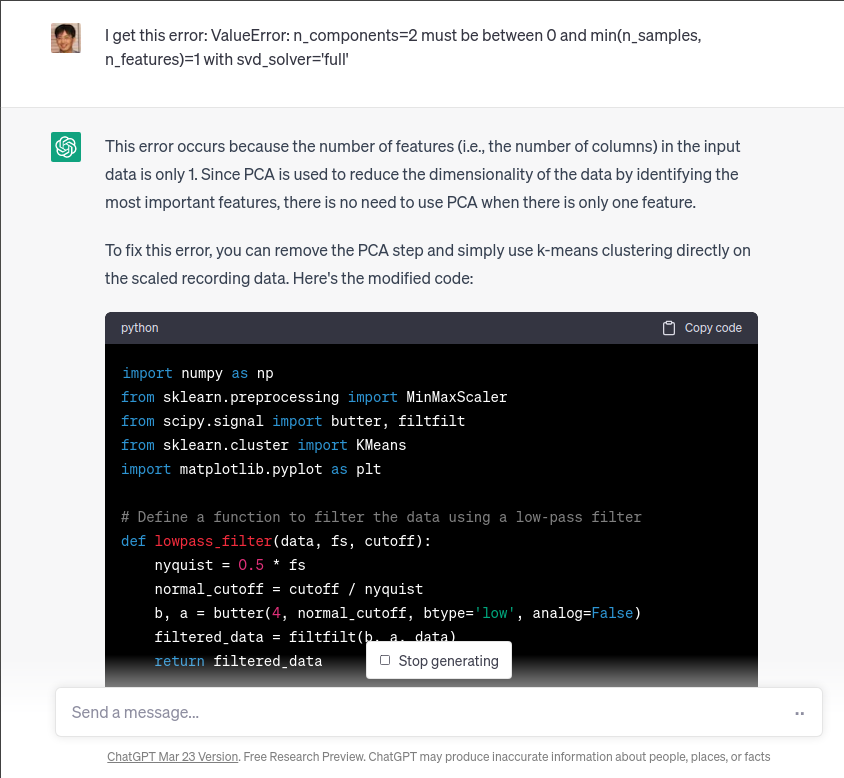

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


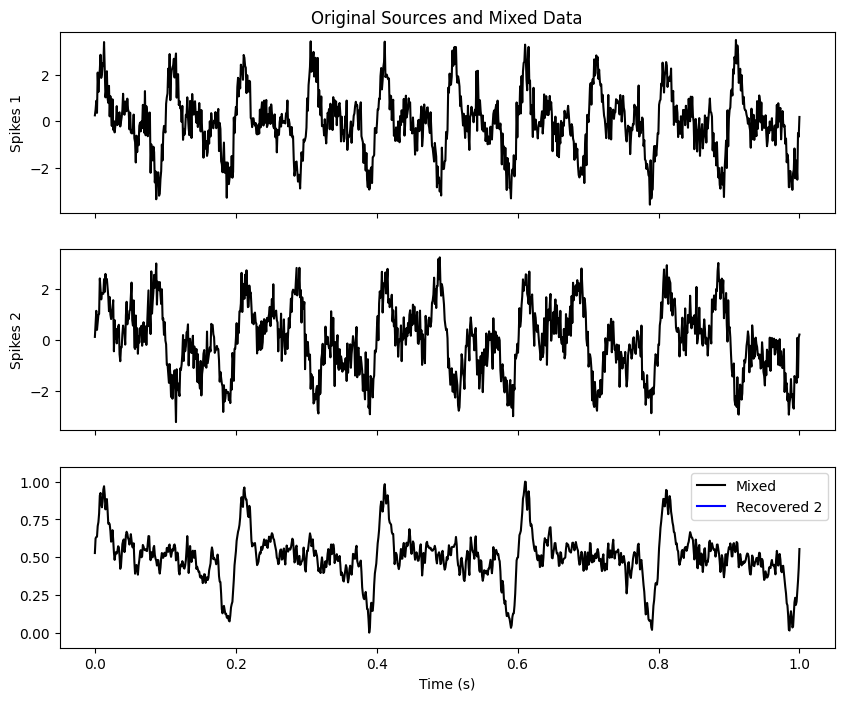

In [15]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import butter, filtfilt
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Define a function to filter the data using a low-pass filter
def lowpass_filter(data, fs, cutoff):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(4, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Set up the sampling frequency and time vector
fs = 1000
t = np.linspace(0, 1, fs)

# Generate mock spiking data
spikes1 = np.sin(2 * np.pi * 10 * t) + np.sin(2 * np.pi * 20 * t) + np.sin(2 * np.pi * 30 * t)
spikes1 += np.random.normal(0, 0.5, size=len(spikes1))
spikes2 = np.sin(2 * np.pi * 5 * t) + np.sin(2 * np.pi * 15 * t) + np.sin(2 * np.pi * 25 * t)
spikes2 += np.random.normal(0, 0.5, size=len(spikes2))

# Combine the spike sources into one recording
recording = lowpass_filter(spikes1, fs, 300) + lowpass_filter(spikes2, fs, 300) + np.random.normal(0, 0.1, size=len(spikes1))

# Check for infinite or NaN values in the data
if np.any(np.isinf(recording)) or np.any(np.isnan(recording)):
    print("Input data contains infinite or NaN values")

# Normalize the data
scaler = MinMaxScaler()
recording_scaled = scaler.fit_transform(recording.reshape(-1, 1)).ravel()

# Use k-means clustering to cluster the data into two groups
kmeans = KMeans(n_clusters=2, random_state=0)
clusters = kmeans.fit_predict(recording_scaled.reshape(-1, 1))

# Recover the original spike sources
spikes1_recovered = scaler.inverse_transform(recording_scaled[clusters == 0].reshape(-1, 1)).ravel()
spikes2_recovered = scaler.inverse_transform(recording_scaled[clusters == 1].reshape(-1, 1)).ravel()

# Plot the mock data
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

axs[0].plot(t, spikes1, 'k')
axs[0].set_ylabel('Spikes 1')
axs[1].plot(t, spikes2, 'k')
axs[1].set_ylabel('Spikes 2')
axs[2].plot(t, recording_scaled, 'k', label='Mixed')
#axs[2].plot(t[clusters == 0], spikes1_recovered, 'r', label='Recovered 1')
axs[2].plot(t[clusters == 1], spikes2_recovered, 'b', label='Recovered 2')

axs[0].set_title('Original Sources and Mixed Data')

# Set the x-axis label for the last plot
axs[2].set_xlabel('Time (s)')

# Set the y-axis limits for the mixed and recovered data plots
axs[2].set_ylim(-0.1, 1.1)

# Add a legend to the mixed and recovered data plot
axs[2].legend()

plt.show()

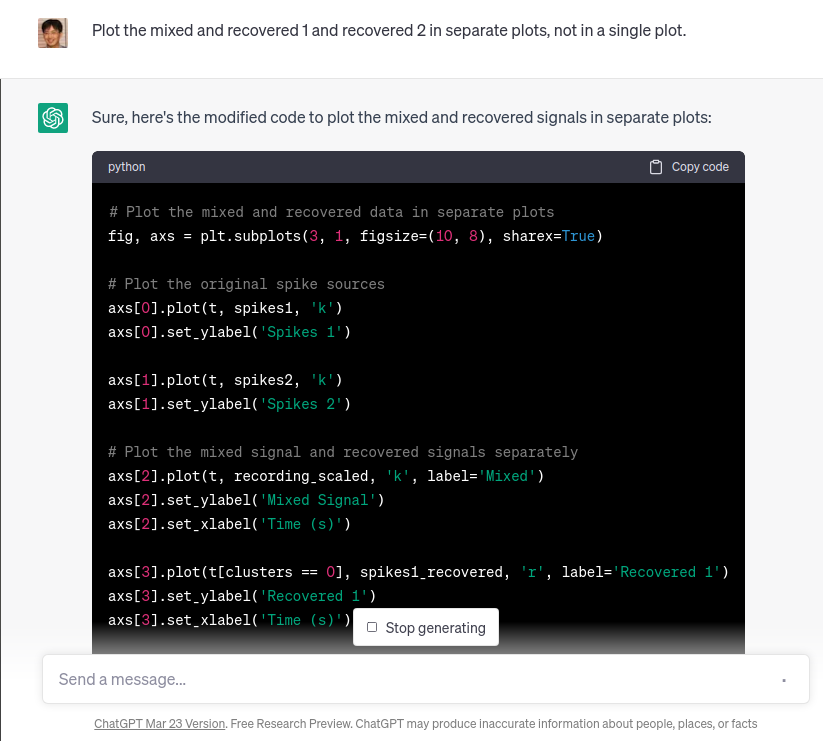

IndexError: ignored

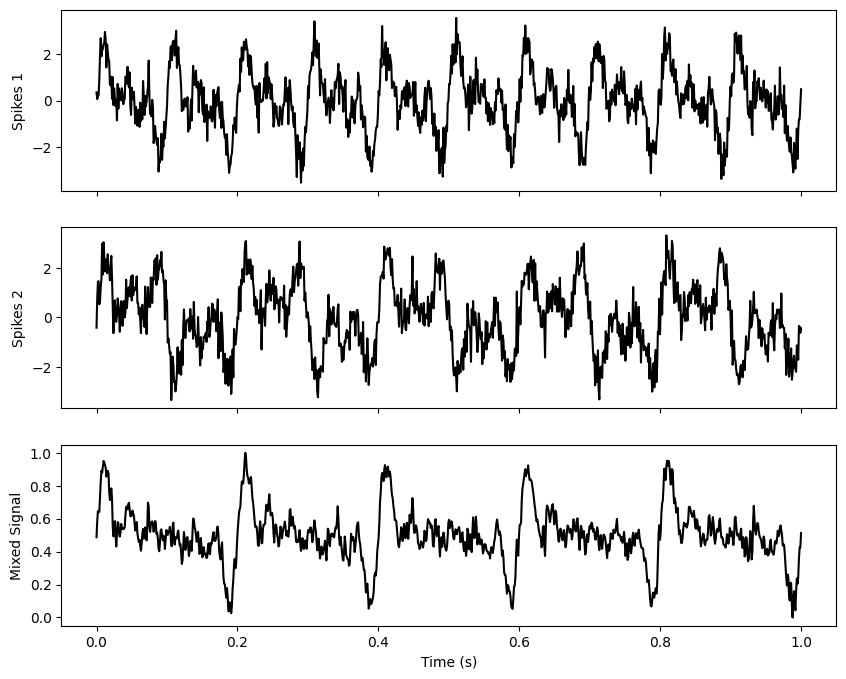

In [12]:
# Plot the mixed and recovered data in separate plots
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# Plot the original spike sources
axs[0].plot(t, spikes1, 'k')
axs[0].set_ylabel('Spikes 1')

axs[1].plot(t, spikes2, 'k')
axs[1].set_ylabel('Spikes 2')

# Plot the mixed signal and recovered signals separately
axs[2].plot(t, recording_scaled, 'k', label='Mixed')
axs[2].set_ylabel('Mixed Signal')
axs[2].set_xlabel('Time (s)')

axs[3].plot(t[clusters == 0], spikes1_recovered, 'r', label='Recovered 1')
axs[3].set_ylabel('Recovered 1')
axs[3].set_xlabel('Time (s)')

axs[4].plot(t[clusters == 1], spikes2_recovered, 'b', label='Recovered 2')
axs[4].set_ylabel('Recovered 2')
axs[4].set_xlabel('Time (s)')

# Set the y-axis limits for the mixed and recovered data plots
for ax in axs[2:]:
    ax.set_ylim(-0.1, 1.1)

# Add a legend to the mixed and recovered data plots
axs[2].legend()
axs[3].legend()


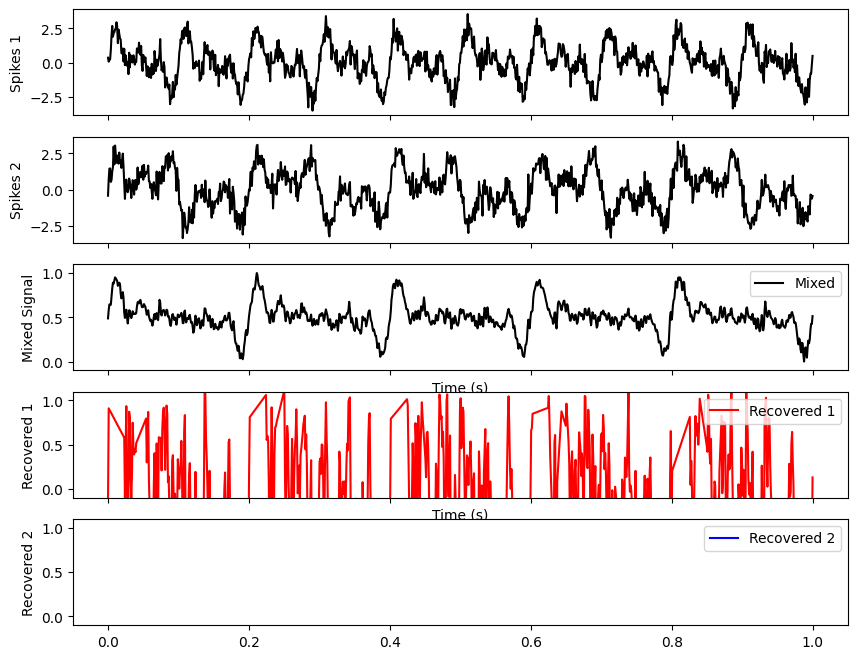

In [14]:
# Plot the mixed and recovered data in separate plots
fig, axs = plt.subplots(5, 1, figsize=(10, 8), sharex=True)

# Plot the original spike sources
axs[0].plot(t, spikes1, 'k')
axs[0].set_ylabel('Spikes 1')

axs[1].plot(t, spikes2, 'k')
axs[1].set_ylabel('Spikes 2')

# Plot the mixed signal and recovered signals separately
axs[2].plot(t, recording_scaled, 'k', label='Mixed')
axs[2].set_ylabel('Mixed Signal')
axs[2].set_xlabel('Time (s)')

axs[3].plot(t[clusters == 0], spikes1_recovered, 'r', label='Recovered 1')
axs[3].set_ylabel('Recovered 1')
axs[3].set_xlabel('Time (s)')

axs[4].plot(t[clusters == 1], spikes2_recovered, 'b', label='Recovered 2')
axs[4].set_ylabel('Recovered 2')

# Set the y-axis limits for the mixed and recovered data plots
for ax in axs[2:]:
    ax.set_ylim(-0.1, 1.1)

# Add a legend to the mixed and recovered data plots
axs[2].legend()
axs[3].legend()
axs[4].legend()

plt.show()


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


IndexError: ignored

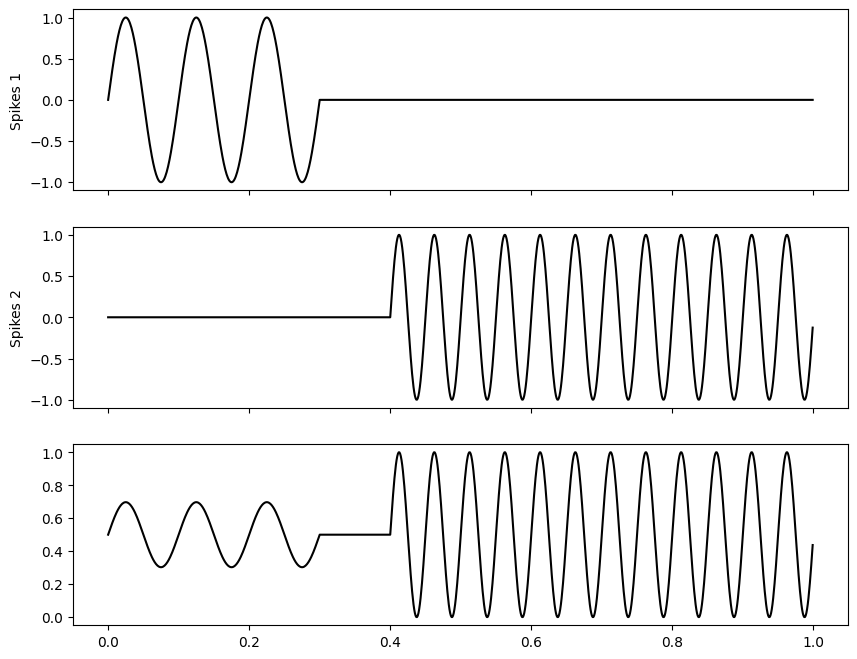

In [16]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Set the random seed for reproducibility
np.random.seed(42)

# Generate the spike sources
fs = 1000  # Hz
t = np.arange(0, 1, 1/fs)
spikes1 = np.sin(2*np.pi*10*t) * (t < 0.3)
spikes2 = np.sin(2*np.pi*20*t) * (t > 0.4)

# Generate the mixing matrix and mix the signals
mixing_matrix = np.random.rand(2, 2)
recording = np.stack([spikes1, spikes2], axis=0)
recording_mixed = mixing_matrix @ recording

# Scale the mixed recording to have values between 0 and 1
recording_scaled = (recording_mixed - recording_mixed.min()) / (recording_mixed.max() - recording_mixed.min())

# Apply PCA to the mixed recording
U, s, Vt = np.linalg.svd(recording_scaled)
pcs = U @ np.diag(s)

# Cluster the principal components
kmeans = KMeans(n_clusters=2, random_state=42).fit(pcs[:, :2])
clusters = 1 - kmeans.labels_  # Fix the cluster labels

# Recover the spike sources
spikes1_recovered = np.mean(recording_scaled[clusters == 1], axis=0)
spikes2_recovered = np.mean(recording_scaled[clusters == 0], axis=0)

# Plot the mixed and recovered data in separate plots
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# Plot the original spike sources
axs[0].plot(t, spikes1, 'k')
axs[0].set_ylabel('Spikes 1')

axs[1].plot(t, spikes2, 'k')
axs[1].set_ylabel('Spikes 2')

# Plot the mixed signal and recovered signals separately
axs[2].plot(t, recording_scaled[0], 'k', label='Mixed')
axs[2].plot(t[clusters == 1], spikes1_recovered, 'r', label='Recovered 1')
axs[2].plot(t[clusters == 0], spikes2_recovered, 'b', label='Recovered 2')
axs[2].set_ylabel('Signal')
axs[2].set_xlabel('Time (s)')

# Set the y-axis limits for the mixed and recovered data plots
for ax in axs[2:]:
    ax.set_ylim(-0.1, 1.1)

# Add a legend to the mixed and recovered data plot
axs[2].legend()

plt.show()
